# Clean Users Analysis

Users are scraped using the `baseline-user-ids.json` input (a list of User IDs) in `twitter_scraper.scrape` - at this point, Users' locations aren't restricted to Croatia only as they will be filtered using the `twitter_scraper.clean` module.

This module reads the scraped User data and filters it by:

* *protected* = False
* *is_croatian* = True
* *statuses_count* > 10
* *friends_count* > 10
* *friends_count* < 5000
* *followers_count* > 10
* *followers_count* < 5000

Resulting with the following data schema:

Column           | Description                                                          | Data Type   
---------------- | -------------------------------------------------------------------- | ------- 
user_id          | Numeric user identifier                                              | int64
created_at       | The UTC datetime that the user account was created on Twitter        | datetime64[ns, UTC]
screen_name      | Alphabetic user identifier                                           | string  
location         | User submitted location                                              | string  
description      | User submitted description                                           | string  
protected        | User allows public access to his profile                             | boolean 
verified         | User is verified by Twitter ([Verified Accounts](https://help.twitter.com/en/managing-your-account/about-twitter-verified-accounts))                                                       | boolean 
followers_count  | Number of accounts that follow the user                              | int64   
friends_count    | Number of accounts that the user follows                             | int64   
listed_count     | Number of public lists that this user is a member of                 | int64   
favourites_count | The number of Tweets this user has liked in the account's lifetime   | int64   
statuses_count   | The number of Tweets (including retweets) issued by the user         | int64   
is_croatian      | Custom value indicating the user's location is Croatian              | bool    
clean_location   | Custom value, aims to pinpoint a Croatian location                   | string  

## Interpreting Croatian Twitter Users

The "Clean Users Analysis" answers the following questions:

* What is the most common Croatian Users location?
* Who are Croatian Users that tweet the most (all-time number of tweets)? Are they verified?
* Which Croatian users are followed the most? 
* Which Croatian users like other tweets the most?

In [5]:
from twitter_scraper.clean.users import USER_DTYPE
from twitter_scraper import settings

import matplotlib.pyplot as plt
import pandas as pd

ANALYZE_COLUMNS = [
    'user_id',
    'screen_name',
    'location',
    'description',
    'protected',
    'verified',
    'followers_count',
    'friends_count',
    'listed_count',
    'favourites_count',
    'statuses_count',
    'created_at',
    'is_croatian',
    'clean_location'
]

users_df = pd.read_csv(settings.CLEAN_USERS_CSV, dtype=USER_DTYPE, parse_dates=['created_at'])
users_df = users_df[ANALYZE_COLUMNS]

In [7]:
users_df.head()

,user_id,screen_name,location,description,protected,verified,followers_count,friends_count,listed_count,favourites_count,statuses_count,created_at,is_croatian,clean_location
0,141690464,TenebrosaVR,Zagreb,<NA>,False,False,11,11,0,0,13,2010-05-08 19:13:48+00:00,True,Zagreb
1,406999528,mojfotoalbum,Hrvatska,MojFotoAlbum je servis za upload fotografija u...,False,False,11,24,1,0,98,2011-11-07 13:54:16+00:00,True,Hrvatska
2,3166104430,WTFPianoDude,Republic of Croatia,Idk what to write!!!!,False,False,11,72,0,116,89,2015-04-14 14:02:36+00:00,True,Hrvatska
3,378154521,CroRuca,Zagreb,I was THE MAN...i am THE MAN...i will always b...,False,False,11,36,0,0,15,2011-09-22 18:44:42+00:00,True,Zagreb
4,222460047,artOmat_sajam,"Zagreb, Hrvatska",artOmat = sajam/radionice/aukcije/izložbe/tulumi,False,False,11,24,0,0,22,2010-12-03 13:51:05+00:00,True,Hrvatska


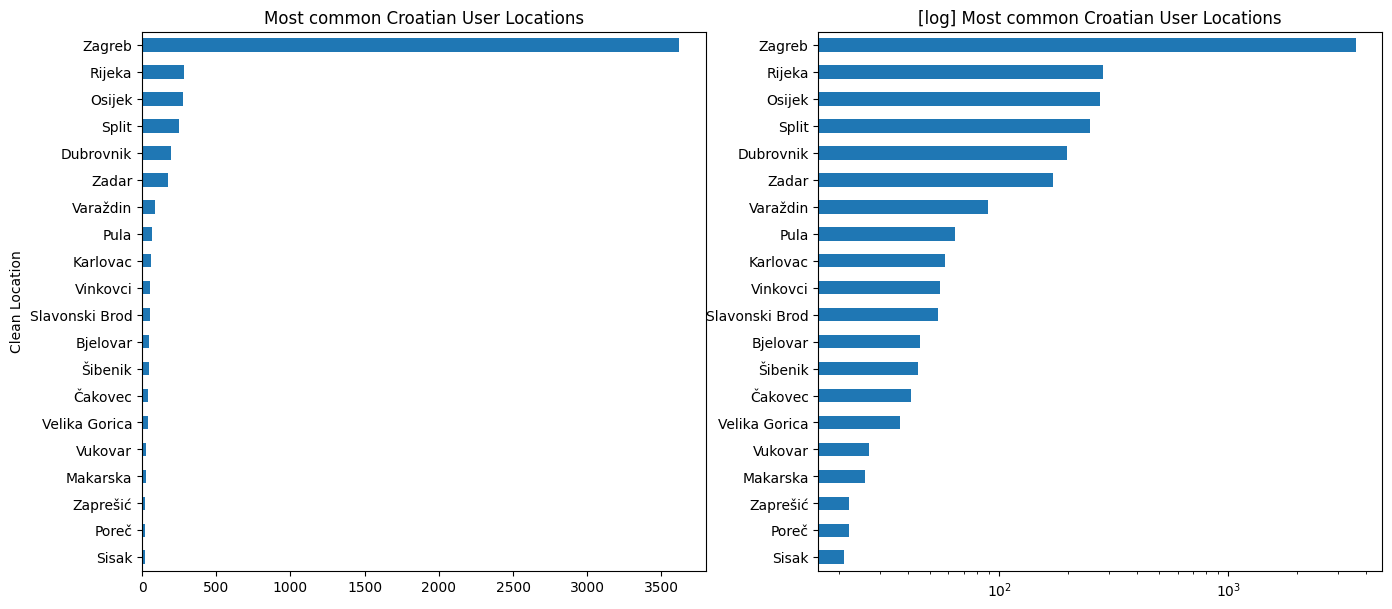

In [110]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

location_df = users_df.groupby('clean_location').size().sort_values()
location_df.drop(['Hrvatska', '🇭🇷', 'Zg'], inplace=True)
location_df.tail(20).plot.barh(ax=axs[0])

axs[0].set_title('Most common Croatian User Locations')
axs[0].set_ylabel('Clean Location')

location_df.tail(20).plot.barh(ax=axs[1])

axs[1].set_title('[log] Most common Croatian User Locations')
axs[1].set_ylabel(None)
axs[1].set_xscale('log')
plt.show()

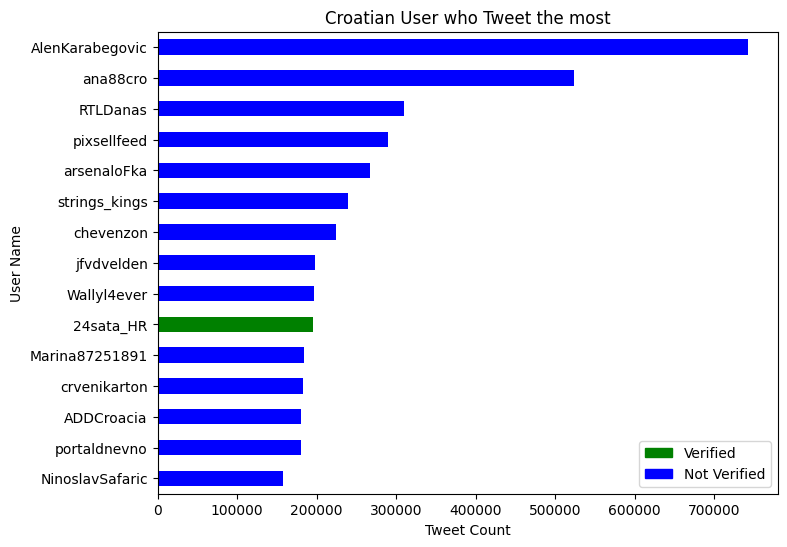

,location,description
screen_name,,
AlenKarabegovic,Republic of Croatia,KEC Global Business Manager - Individual Globa...
ana88cro,Croatia🇭🇷Zadar🇭🇷,🔞ADULT ONLY 🔞
RTLDanas,Zagreb,"Središnja informativna emisija @RTLtelevizija,..."
pixsellfeed,"Zagreb, Croatia",News feed by PIXSELL photo and video agency fr...
arsenaloFka,"Varaždin, Croatia","Mrs @RiouGenaku, mom, #arsenal, pizza. @dailyc..."
strings_kings,"Zagreb, Croatia",free style. quick observation. no sorry.
chevenzon,Bale,@chevnzn https://t.co/F5hsrxVOQA
jfvdvelden,"Sveti lovrec, hrvatska",Bekijk wat ik heb gepost op Google Maps Niveau...
Wallyl4ever,Republic of Croatia,Decisions have been made the die has been cast


In [94]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1, figsize=(8, 6))

most_tweeters_df = users_df[['screen_name', 'location', 'description', 'verified', 'statuses_count']] \
  .set_index('screen_name').sort_values(by='statuses_count')
most_tweeters_df['color'] = most_tweeters_df['verified'].transform(lambda x: 'green' if x else 'blue')
most_tweeters_df['statuses_count'].tail(15).plot.barh(ax=ax, color=most_tweeters_df.tail(15)['color'])

ax.set_title('Croatian User who Tweet the most')
ax.set_xlabel('Tweet Count')
ax.set_ylabel('User Name')

VER = mpatches.Patch(color='green', label='Verified')
NOT_VER = mpatches.Patch(color='blue', label='Not Verified')
ax.legend(handles=[VER, NOT_VER])

plt.show()
most_tweeters_df[['location', 'description']].tail(15).iloc[::-1]

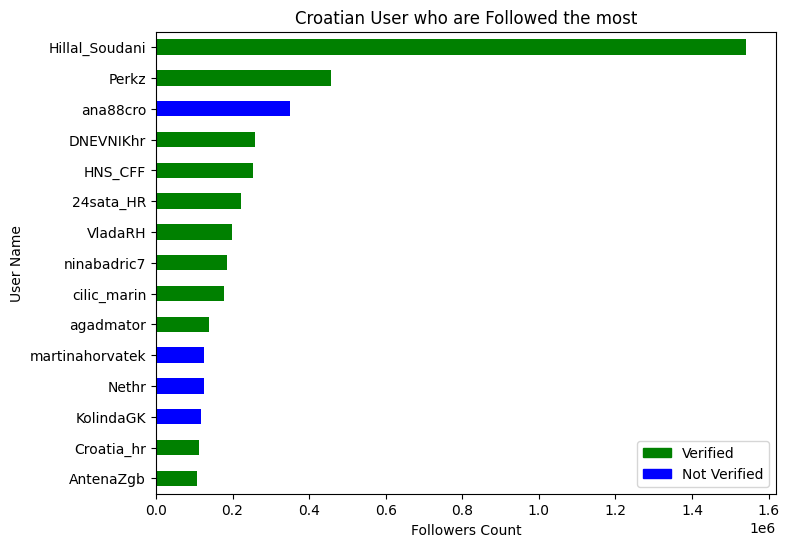

,location,description
screen_name,,
Hillal_Soudani,"Zagreb,croatie",Professional Footballer 2️⃣- Currently playing...
Perkz,Croatia,🇭🇷 24 years old. Professional League of Legend...
ana88cro,Croatia🇭🇷Zadar🇭🇷,🔞ADULT ONLY 🔞
DNEVNIKhr,Republic of Croatia,Saznajte prvi najvažnije informacije #dnevnikhr
HNS_CFF,Hrvatska | Croatia,Službeni Twitter profil Hrvatskog nogometnog s...
24sata_HR,"Zagreb, Croatia",dnevna doza tweetova s našeg portala
VladaRH,Croatia,Vlada Republike Hrvatske - službeni Twitter ra...
ninabadric7,Zagreb Croatia,new song ‘da biram’ https://t.co/NRU2PIqtYj
cilic_marin,Croatia,Professional tennis player 🎾


In [95]:
fig, ax = plt.subplots(1, figsize=(8, 6))

most_tweeters_df = users_df[['screen_name', 'location', 'description', 'verified', 'followers_count']] \
  .set_index('screen_name').sort_values(by='followers_count')
most_tweeters_df['color'] = most_tweeters_df['verified'].transform(lambda x: 'green' if x else 'blue')
most_tweeters_df['followers_count'].tail(15).plot.barh(ax=ax, color=most_tweeters_df.tail(15)['color'])

ax.set_title('Croatian User who are Followed the most')
ax.set_xlabel('Followers Count')
ax.set_ylabel('User Name')

VER = mpatches.Patch(color='green', label='Verified')
NOT_VER = mpatches.Patch(color='blue', label='Not Verified')
ax.legend(handles=[VER, NOT_VER])

plt.show()
most_tweeters_df[['location', 'description']].tail(15).iloc[::-1]


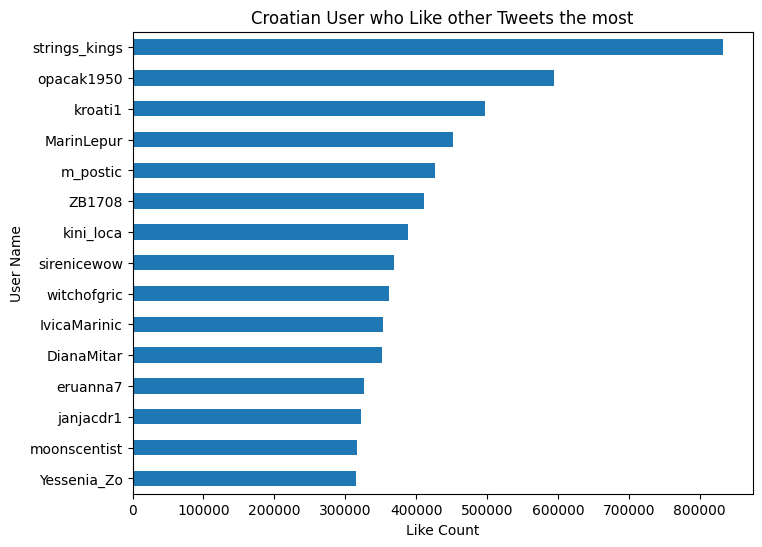

,location,description
screen_name,,
strings_kings,"Zagreb, Croatia",free style. quick observation. no sorry.
opacak1950,"Republic of Croatia, Osijek","26 years old. Volim Hajduk, sport, filmove i k..."
kroati1,Croatia / Mateus,FFXIV-posting│ Please listen to my advice │SFS...
MarinLepur,"Zadar, Republic of Croatia",22 | Future starving artist
m_postic,Zagreb,"Ja sam ovaj desni, ali samo na slici, politick..."
ZB1708,Zadar,""" Bijah, jesam, bit ću"""
kini_loca,Croatia,i rarely tweet but when i do it's mostly song ...
sirenicewow,"Zagreb, Croatia",Cada esquina de este circulo al revés. ...
witchofgric,"Zagreb, Croatia","Wife, mom, reader, music lover (and a kitchen ..."


In [100]:
fig, ax = plt.subplots(1, figsize=(8, 6))

most_tweeters_df = users_df[['screen_name', 'location', 'description', 'verified', 'favourites_count']] \
  .set_index('screen_name').sort_values(by='favourites_count')
most_tweeters_df['favourites_count'].tail(15).plot.barh(ax=ax)

ax.set_title('Croatian User who Like other Tweets the most')
ax.set_xlabel('Like Count')
ax.set_ylabel('User Name')

plt.show()
most_tweeters_df[['location', 'description']].tail(15).iloc[::-1]
